In [1]:
input_dim = 13166
num_clusters = 18

model_file = "/home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
pc_matrix_file = "/home/gregory/Desktop/ELDR/Bipolar/Data/bipolar_pc.tsv"

import csv
import json
import numpy as np
import os
import pandas as pd

from load_vae import load_vae

import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from metrics import metrics, eval_epsilon
from plot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file, feature_transform = pc_matrix_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/bipolar_rep_scaled.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Approximate the original data

matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


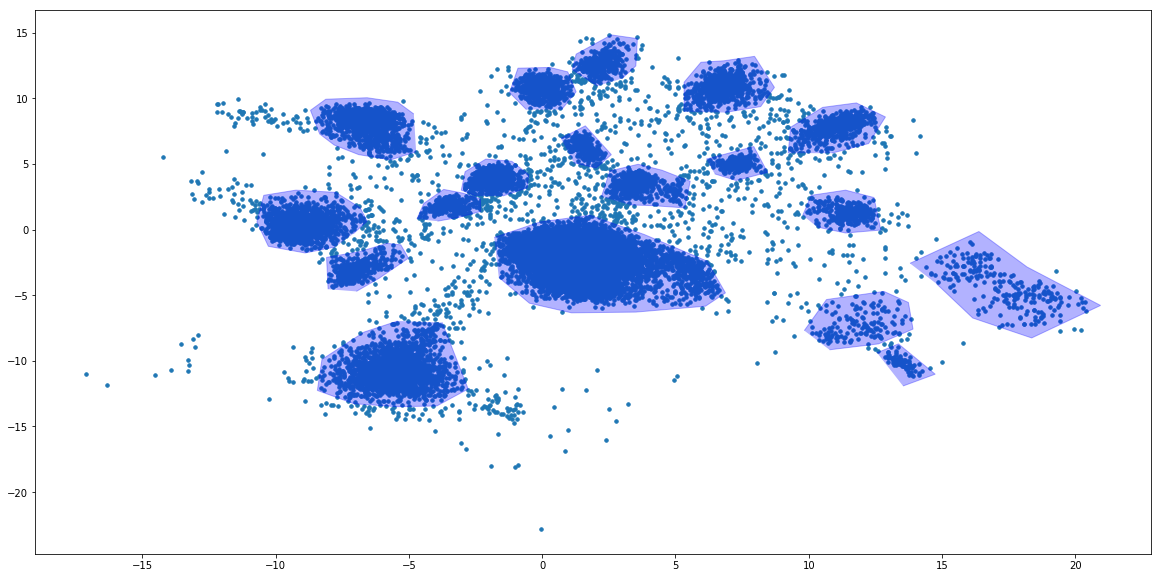

In [5]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)

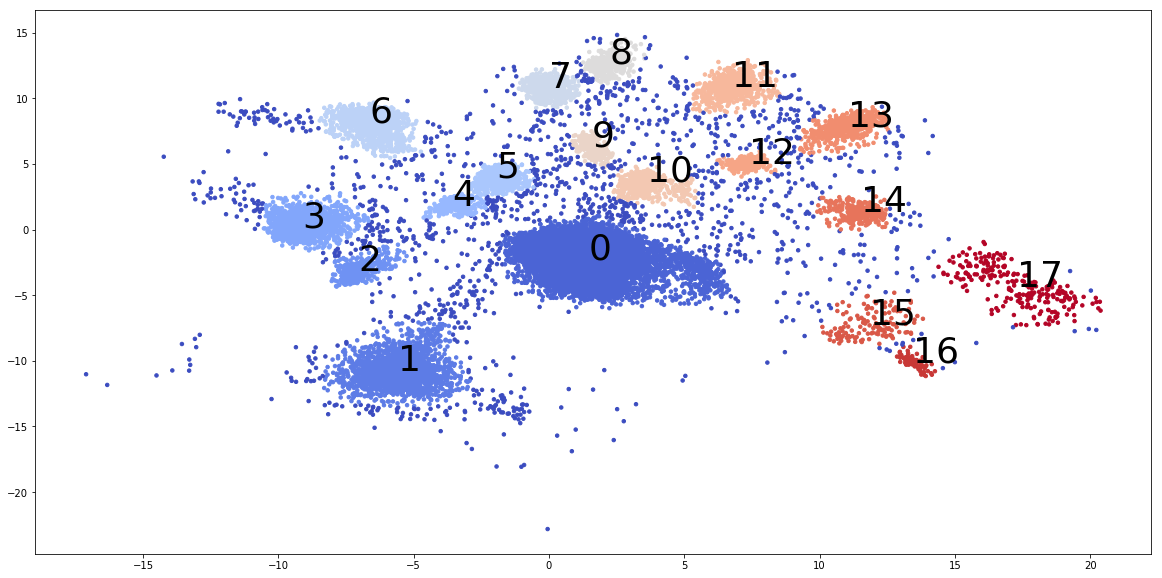

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "bipolar-rep.png")


In [7]:
# Set epsilon for our metrics

epsilon = 0.75

if True:
    eval_epsilon(load_model, x_full, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


In [8]:
# Compute the group explanations

if False:

    def args2name(l1, cs, lr, trial):
        return "explanation/" + str(l1) + "/" + str(cs) + "/" + str(lr) + "/trial" + str(trial)
    
    results = {}

    os.system("rm -rf explanation")
    os.system("rm results.txt")

    for lr in [0.0001, 0.0005]:
        for cs in [5, 10]:
            for l1 in [7500, 10000, 12500]:
                for trial in [1,2,3,4,5,6,7,8,9,10]:

                    name = args2name(l1, cs, lr, trial)

                    cwd = os.getcwd()

                    os.makedirs(name)
                    os.chdir(name)

                    deltas = explain(load_model, means, centers, learning_rate = lr, consecutive_steps = cs, lambda_global = l1)

                    np.save("deltas.npy", deltas)

                    a, b = metrics(load_model, x_full, indices, deltas, epsilon)

                    plot_metrics(a, b, name = "metrics.png")

                    val = np.mean(a)
                    
                    results[name] = val

                    os.chdir(cwd)
        
    sorted_results = sorted(results.items(), key=lambda x: -1.0 * x[1])

    with open("results.txt", "w") as f:
        for item in sorted_results:
            f.write("%s\n" % str(item))
                    

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


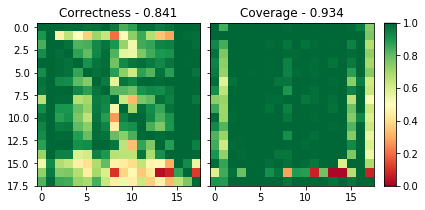

In [9]:
best_config = 'explanation/7500/5/0.0005/trial1' #sorted_results[0][0]

deltas = np.load(best_config + "/deltas.npy")

a, b = metrics(load_model, x_full, indices, deltas, epsilon)

plot_metrics(a, b, "bipolar-metrics.png")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


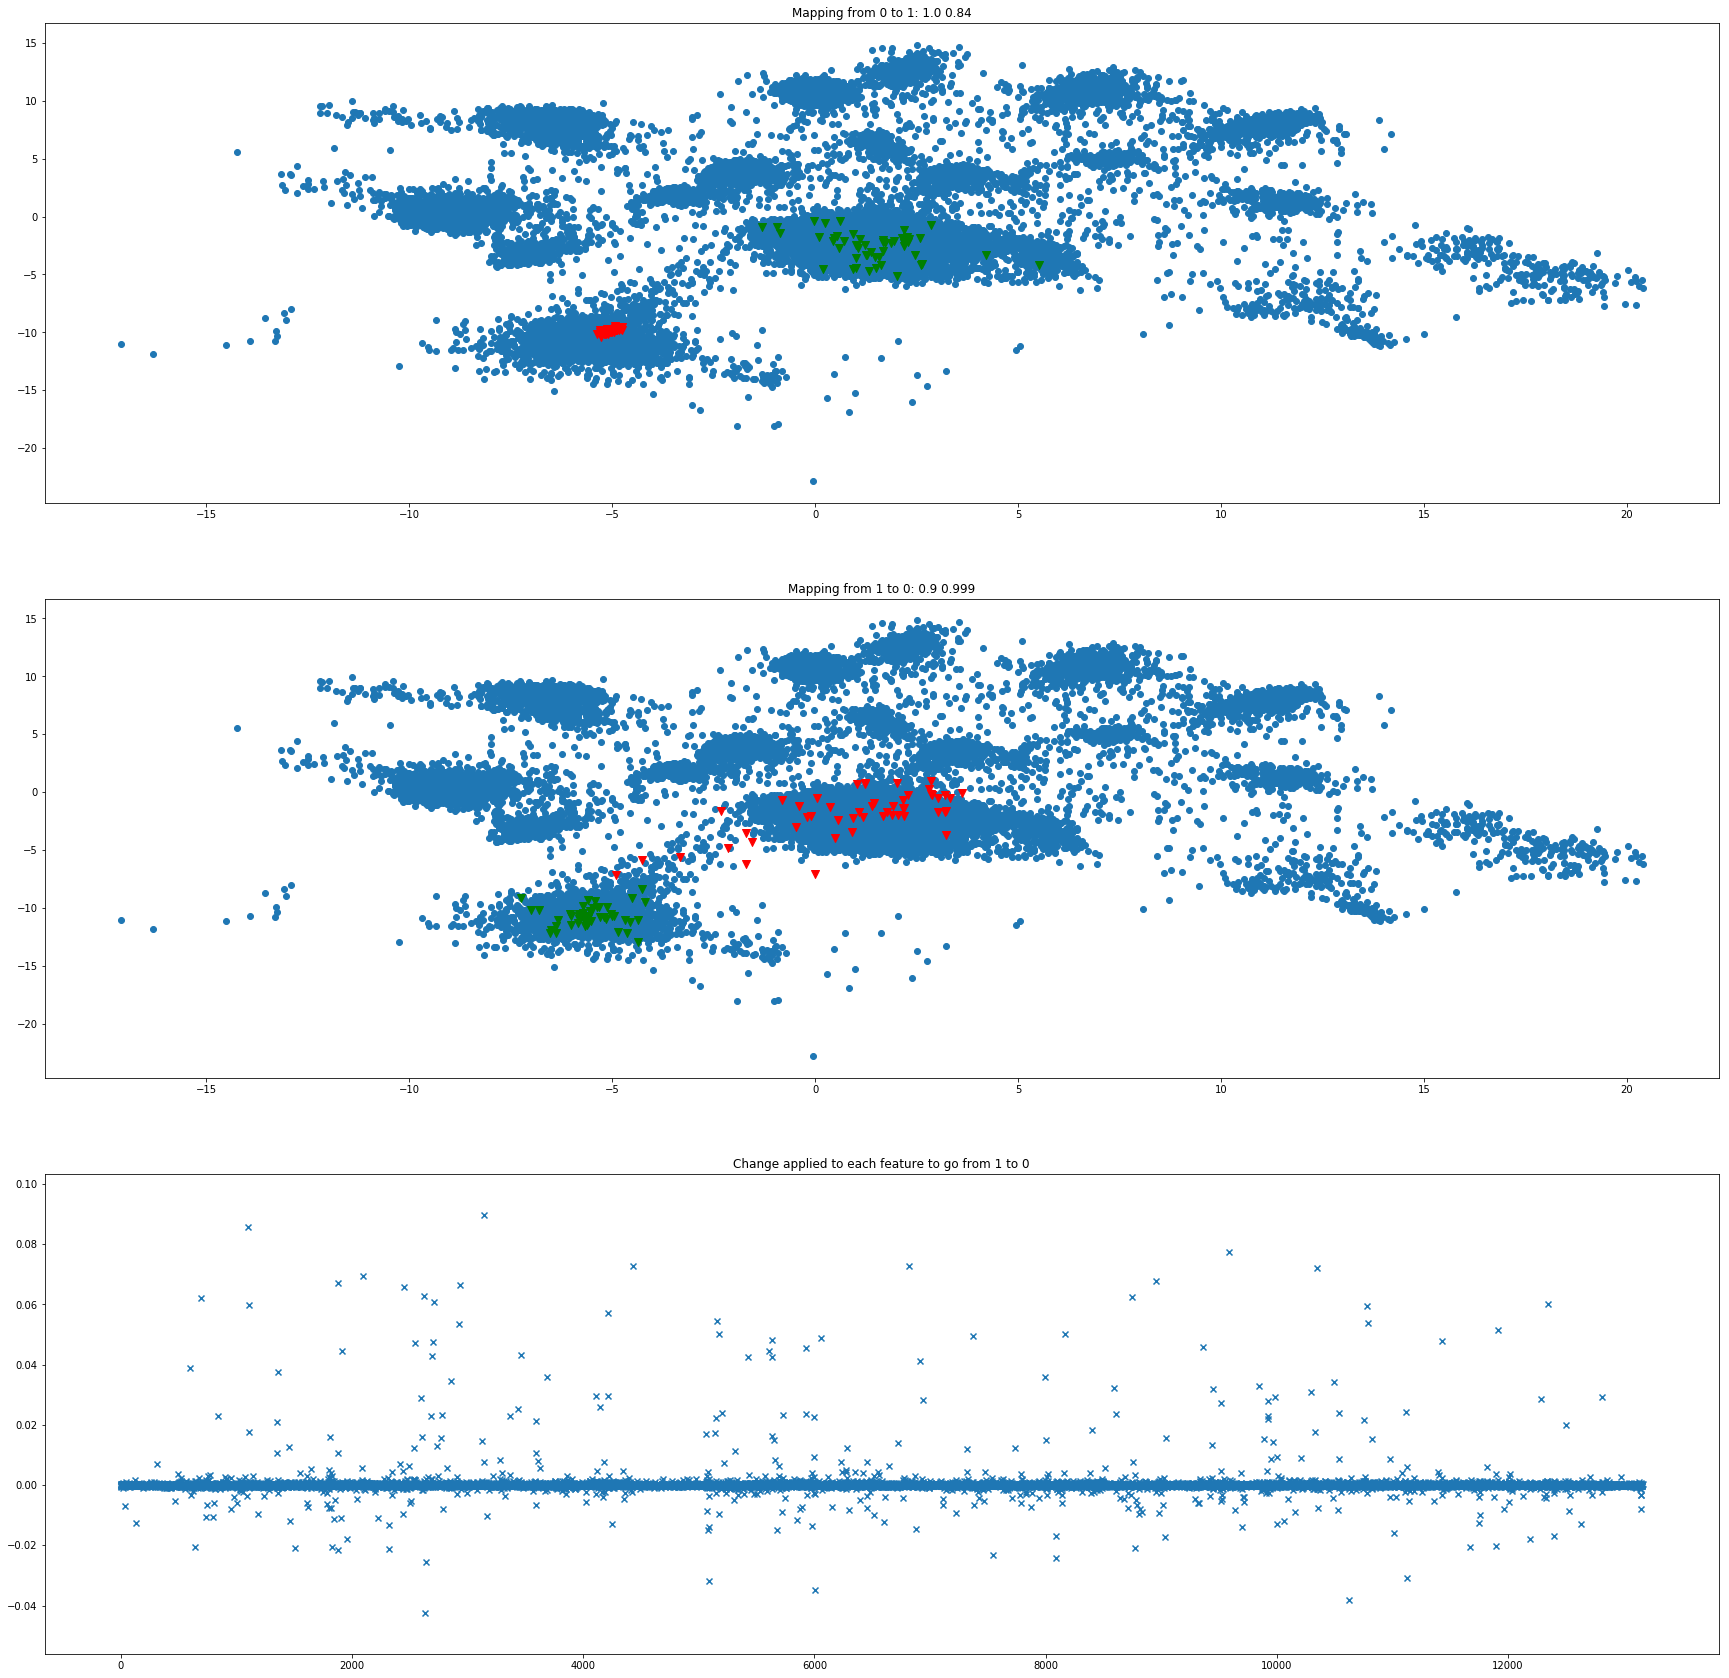

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


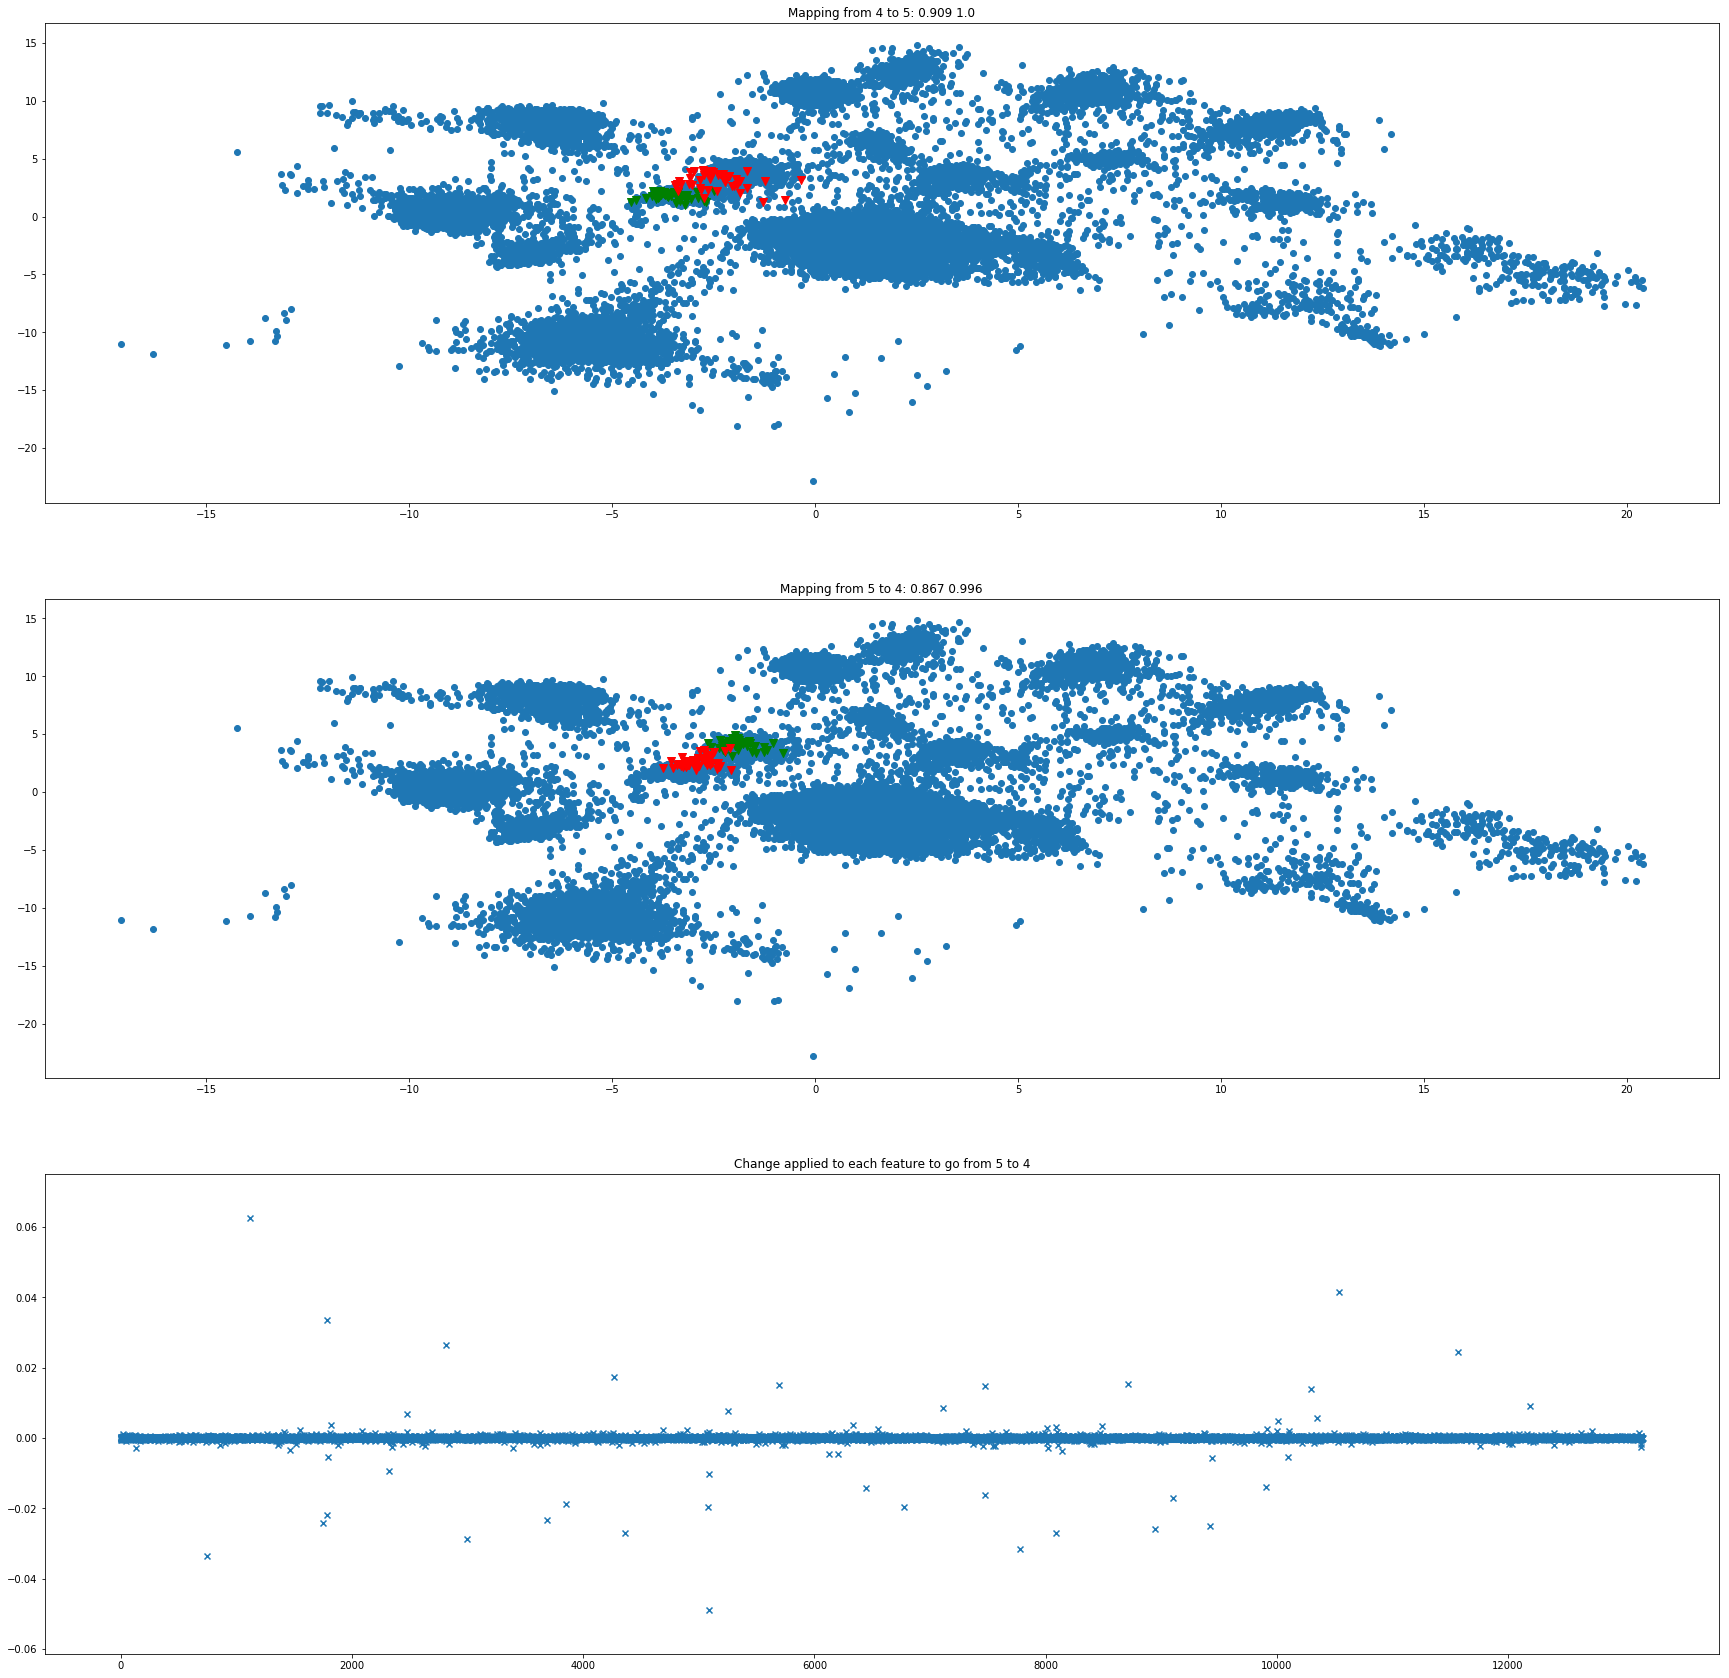

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


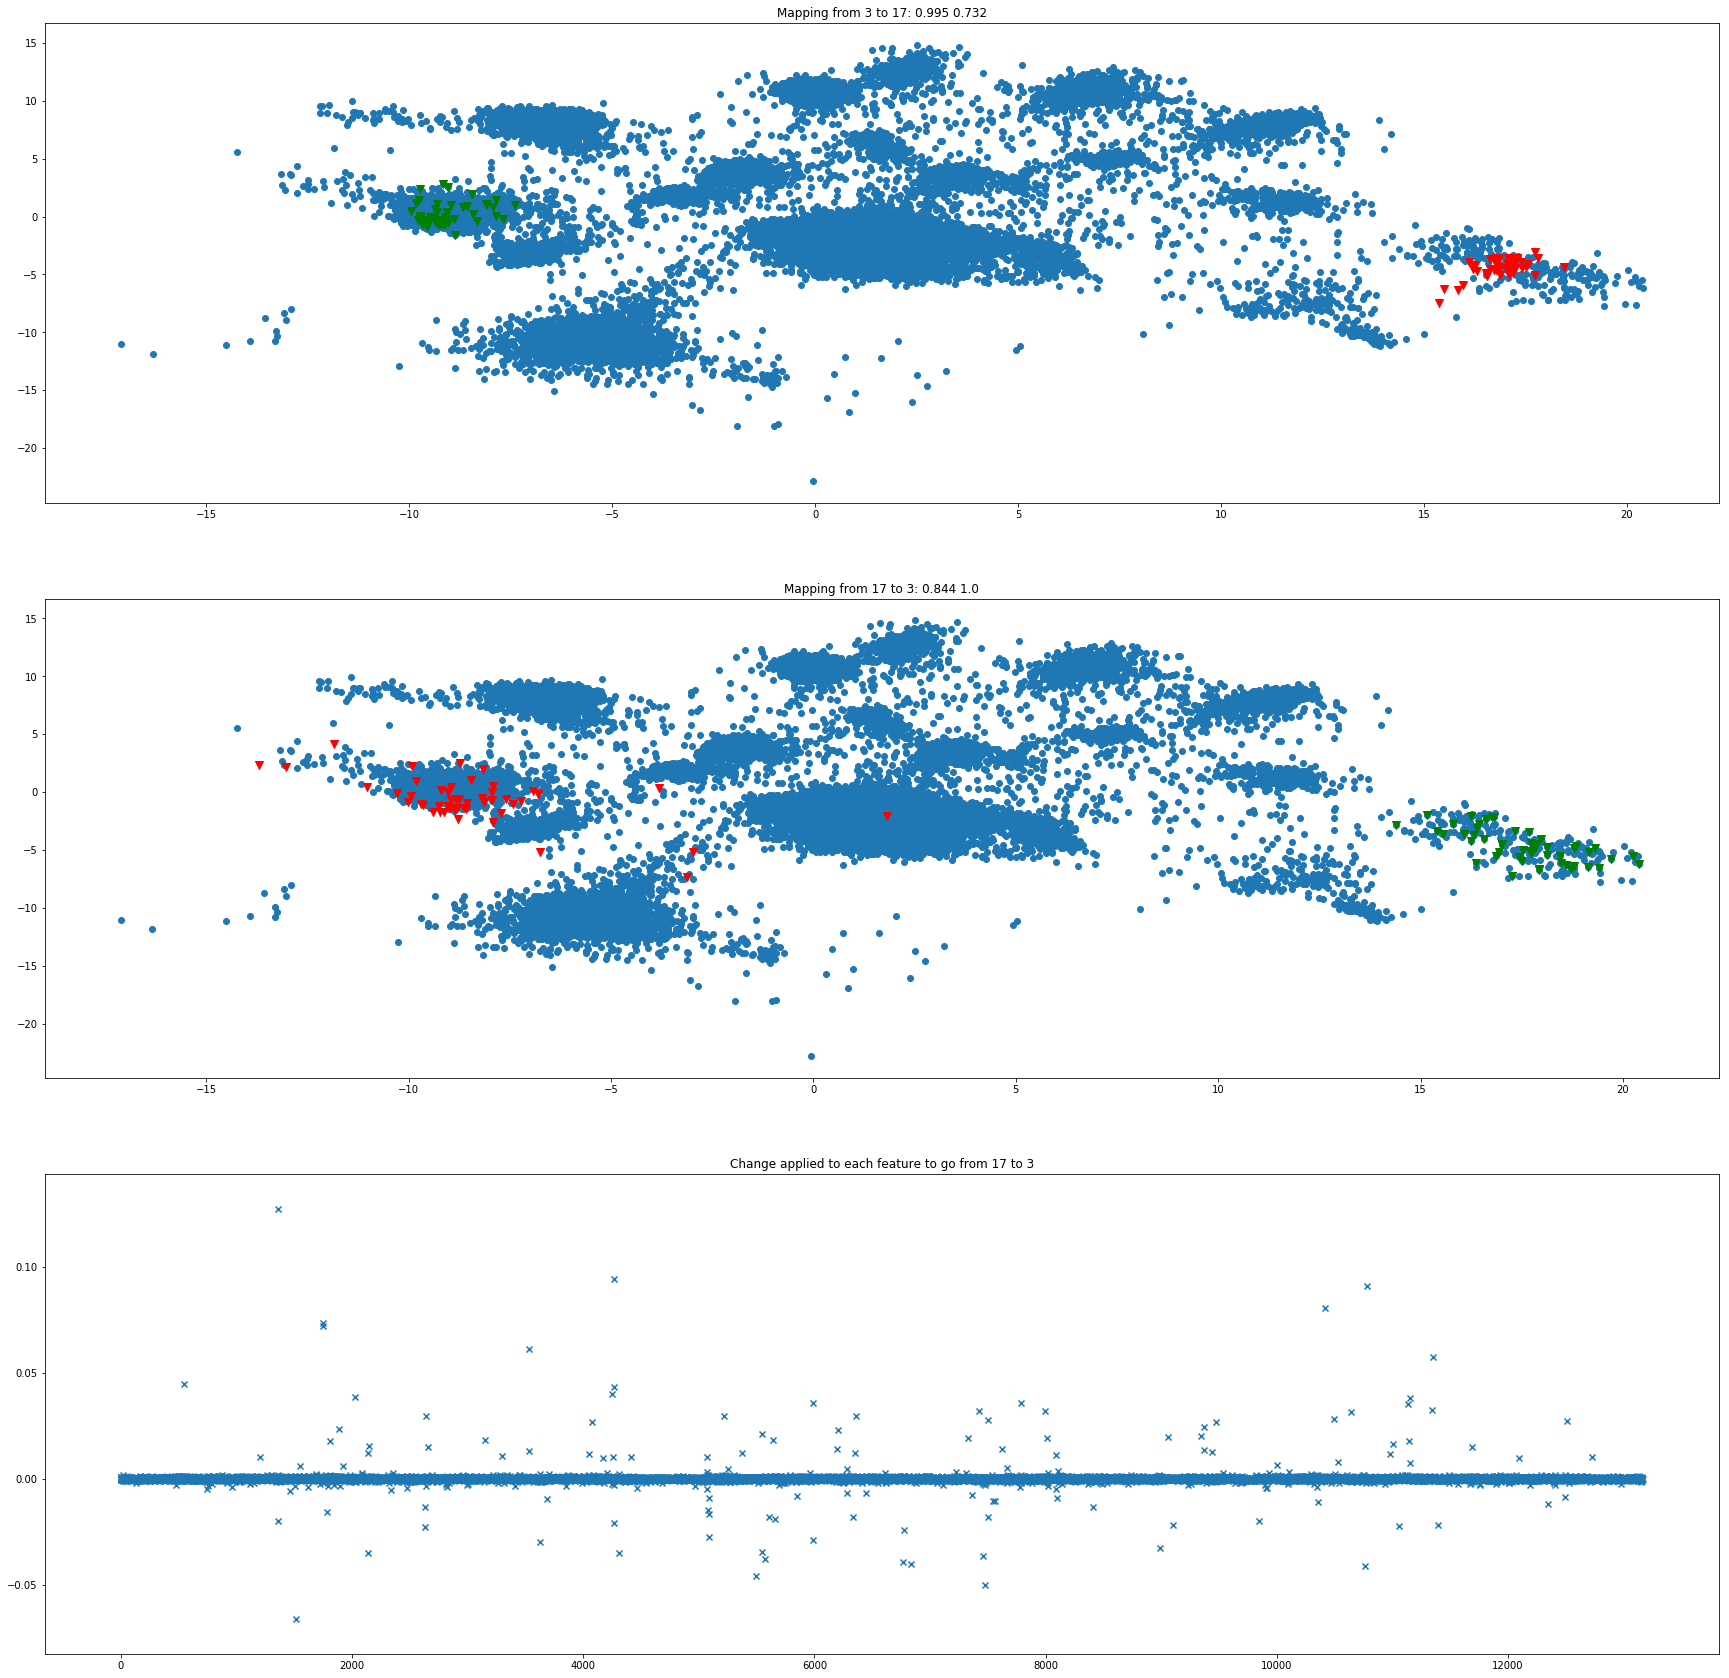

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


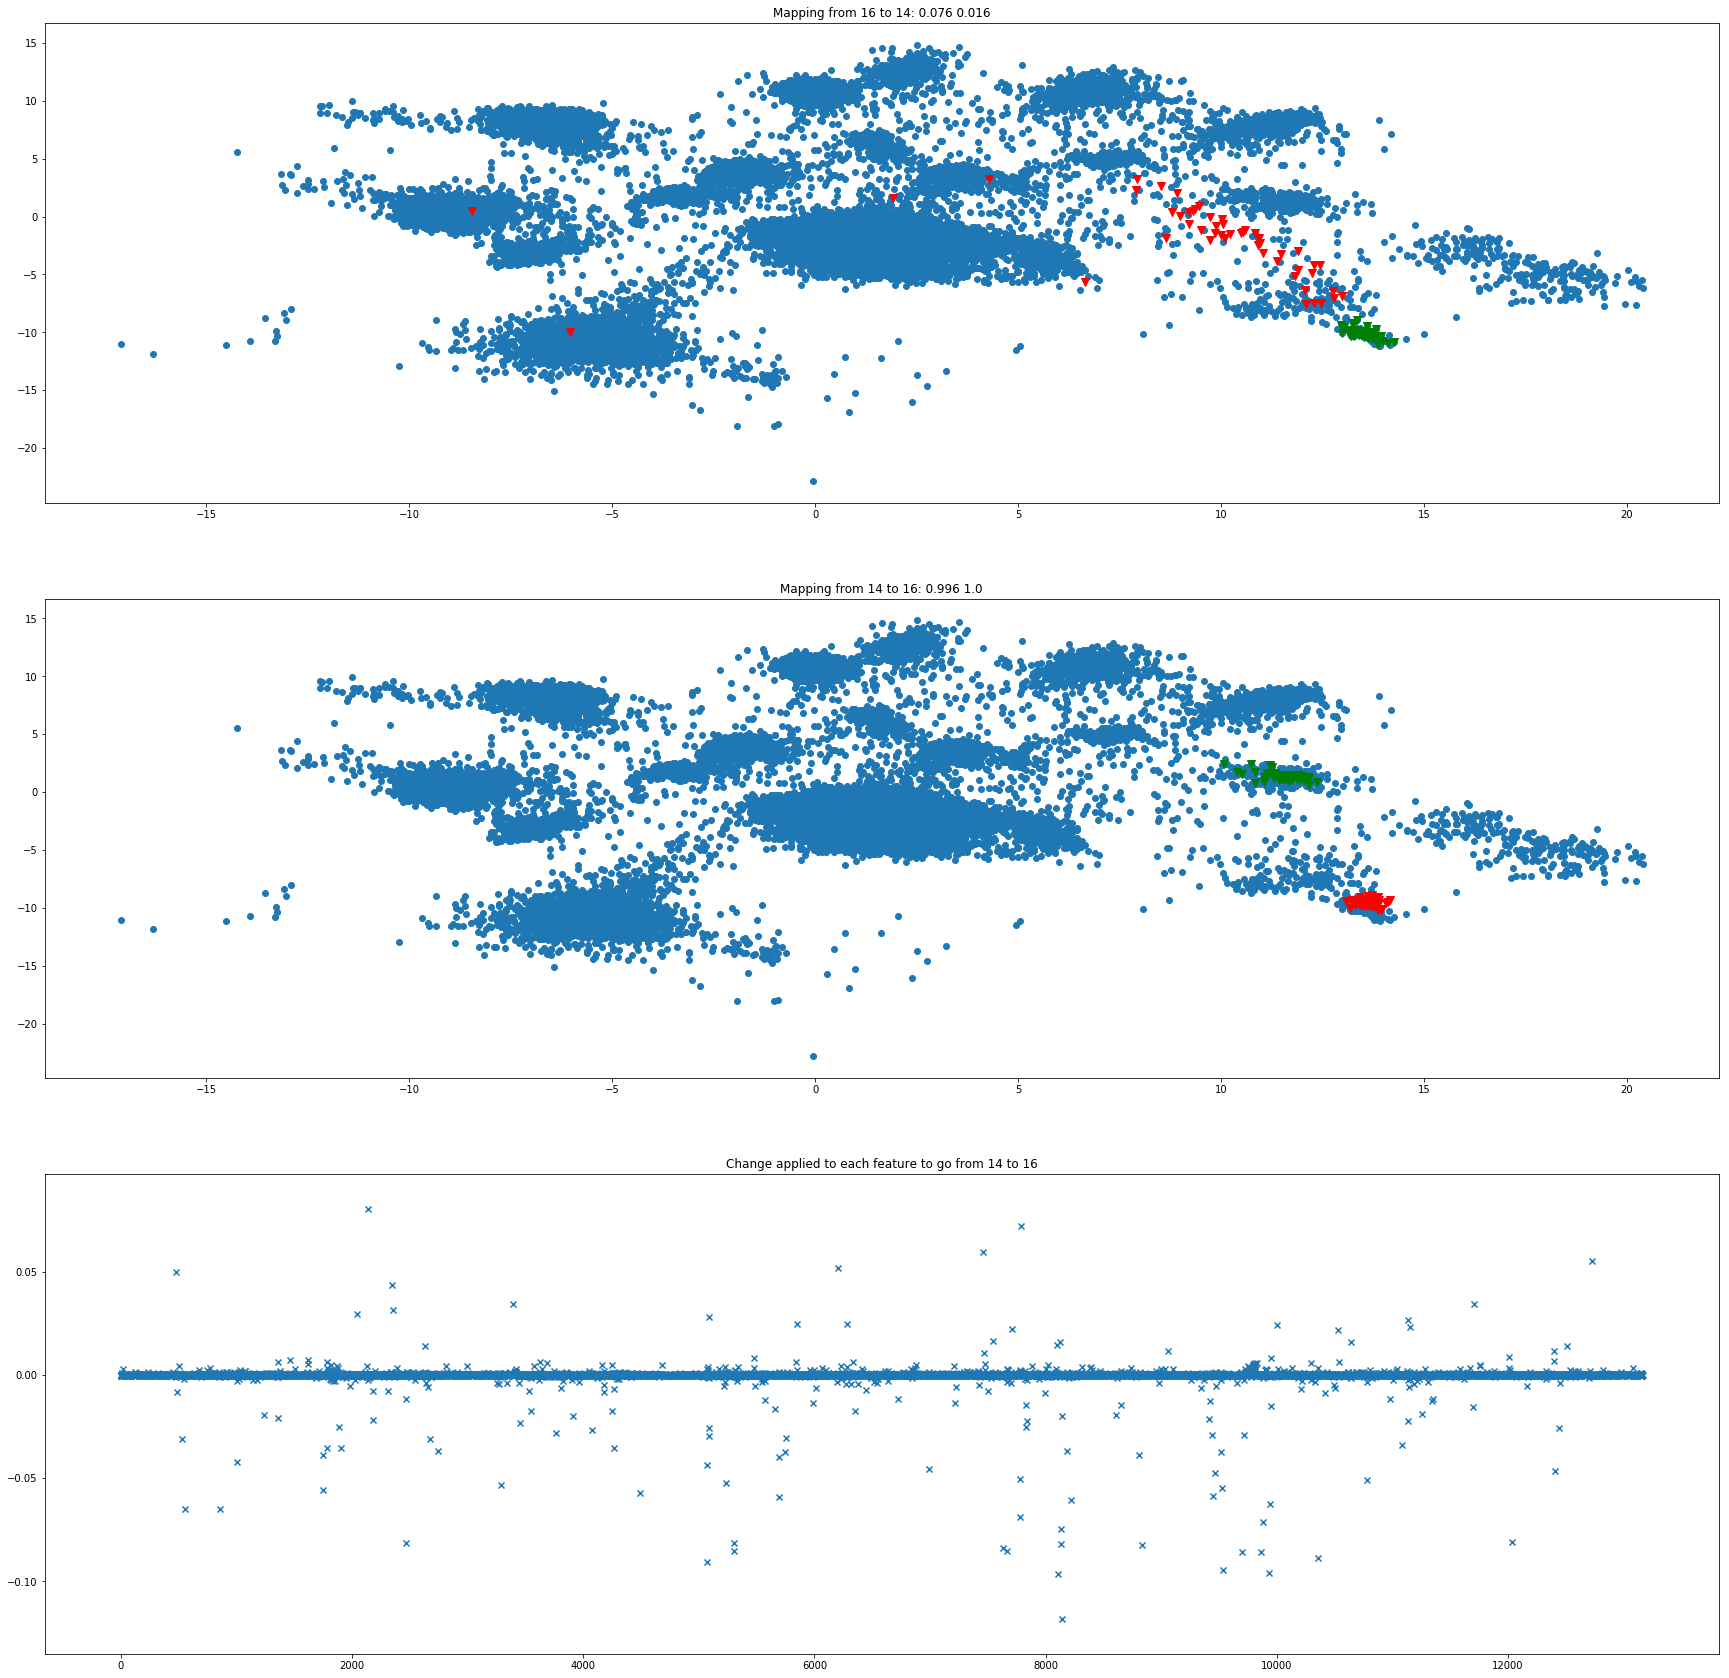

In [10]:
# Visualize the group explanations

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 0, 1, name = "bipolar-simple.png")

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 4, 5, name = "bipolar-close.png")

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 3, 17, name = "bipolar-far.png")

plot_explanation(load_model, x_full, data_rep, indices, deltas, a, b, 16, 14, name = "bipolar-hard.png")
